<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/antehoc/AttentionWeightsTrying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate

# Download stock data using yfinance
symbol = "^BVSP"
data = yf.download(symbol, start="2020-01-01", end="2022-01-01")
df = pd.DataFrame(data['Adj Close'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Create sequences for training
sequence_length = 1
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length])
    y.append(df_scaled[i+sequence_length])

X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model with attention mechanism
input_layer = Input(shape=(sequence_length, 1))
lstm_layer = LSTM(50, return_sequences=True)(input_layer)
attention = Attention()([lstm_layer, lstm_layer])
context = attention * lstm_layer
output_layer = Dense(1)(context)

# Concatenate the output and attention weights
model = Model(inputs=input_layer, outputs=[output_layer, attention])
model.compile(optimizer='adam', loss=['mean_squared_error', None])

# Train the model
model.fit(X_train, [y_train, np.zeros_like(y_train)], epochs=50, batch_size=32, validation_data=(X_test, [y_test, np.zeros_like(y_test)]))


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
13/13 [==============================] - 3s 52ms/step - loss: 0.4790 - dense_loss: 0.4790 - val_loss: 0.4190 - val_dense_loss: 0.4190
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4594 - dense_loss: 0.4594 - val_loss: 0.4009 - val_dense_loss: 0.4009
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4397 - dense_loss: 0.4397 - val_loss: 0.3823 - val_dense_loss: 0.3823
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4189 - dense_loss: 0.4189 - val_loss: 0.3624 - val_dense_loss: 0.3624
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 0.3963 - dense_loss: 0.3963 - val_loss: 0.3406 - val_dense_loss: 0.3406
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.3713 - dense_loss: 0.3713 - val_loss: 0.3161 - val_dense_loss: 0.3161
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.3424 - dense_loss: 0.3424 - val_loss: 0.2883 - val_dense_loss

In [2]:
# Predict on the test set
predictions, attention_weights = model.predict(X_test)


4/4 [==============================] - 0s 3ms/step


In [3]:
train_predictions, train_attention_weights = model.predict(X_train)


13/13 [==============================] - 0s 2ms/step


In [4]:
train_attention_weights[:,:,0].shape

(395, 1)

In [5]:
y_train.shape

(395, 1)

In [6]:
attention_weights.shape

(99, 1, 50)

In [7]:
predictions.reshape(-1,1).shape

(99, 1)

In [8]:
y_test.shape

(99, 1)

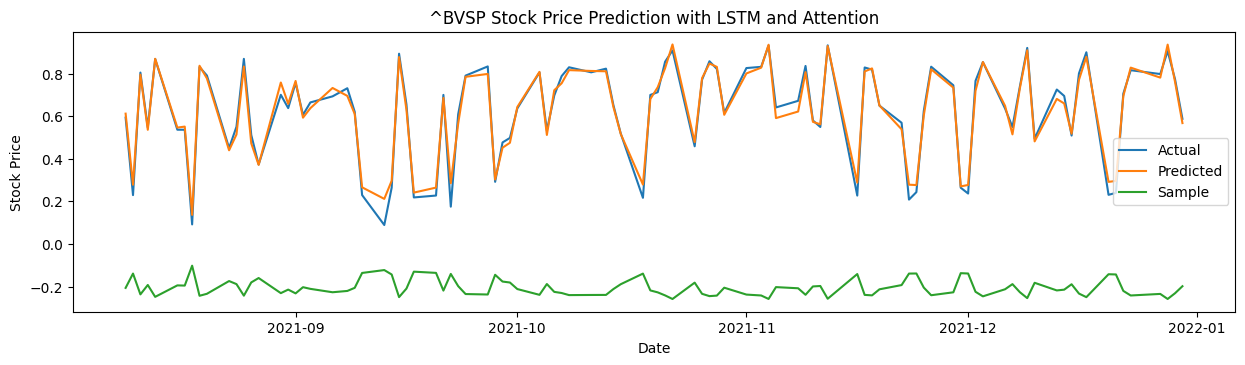

In [9]:
## Inverse transform the predictions and actual values to get them in the original scale
##predictions = scaler.inverse_transform(predictions)
#y_test_original = scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(predictions):], predictions.reshape(-1,1), label='Predicted')
plt.plot( df.index[-len(attention_weights):], attention_weights[:,:,49], label='Sample')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()



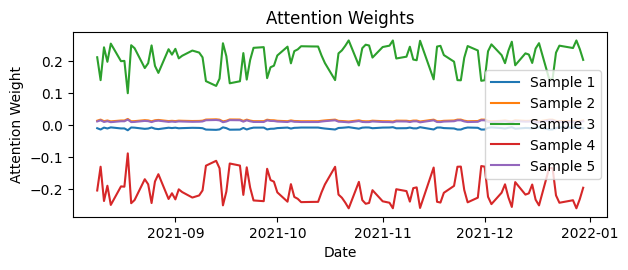

In [14]:
# Plotting attention weights
plt.subplot(2, 1, 2)
for i in range(5):  # Plot attention weights for the first 5 samples in the test set
    plt.plot(df.index[-len(attention_weights):], attention_weights[:, :, i], label=f'Sample {i + 1}')

plt.title('Attention Weights')
plt.xlabel('Date')
plt.ylabel('Attention Weight')
plt.legend()

plt.tight_layout()
plt.show()


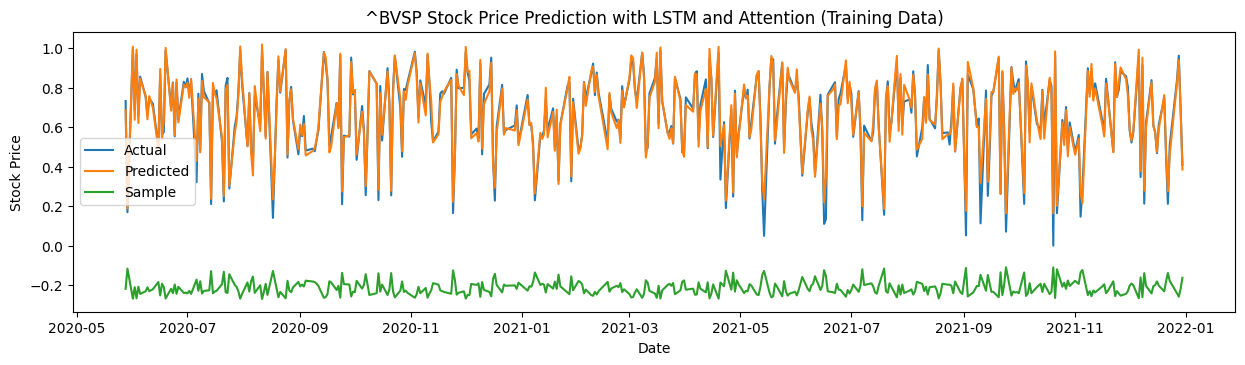

In [26]:
# Plot the attention weights for the training data
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_train):], y_train, label='Actual')
plt.plot(df.index[-len(train_predictions):], train_predictions.reshape(-1,1), label='Predicted')
plt.plot( df.index[-len(train_attention_weights):], train_attention_weights[:,:,49], label='Sample')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention (Training Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()



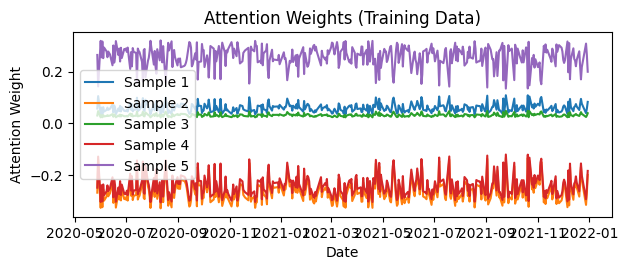

In [ ]:

# Plotting attention weights for the training data
plt.subplot(2, 1, 2)
for i in range(5):  # Plot attention weights for the first 5 samples in the training set
    plt.plot(df.index[-len(train_attention_weights):], train_attention_weights[:, :, i], label=f'Sample {i + 1}')

plt.title('Attention Weights (Training Data)')
plt.xlabel('Date')
plt.ylabel('Attention Weight')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
train_attention_weights.shape

(395, 1, 50)

In [ ]:
mean_attention_weights = np.max(train_attention_weights.reshape(-1,50), axis=1)
mean_attention_weights

array([0.264203  , 0.18390787, 0.31874985, 0.25489253, 0.31643662,
       0.2517137 , 0.2929539 , 0.27790305, 0.25541458, 0.27741626,
       0.26636836, 0.22420573, 0.3009335 , 0.23453309, 0.2544402 ,
       0.3178401 , 0.26383594, 0.28885162, 0.23883952, 0.29208836,
       0.25227535, 0.28757662, 0.28552747, 0.2892332 , 0.2758173 ,
       0.2926581 , 0.20989367, 0.2751095 , 0.21988966, 0.29077417,
       0.2764048 , 0.27190834, 0.17382579, 0.28907332, 0.27979895,
       0.2753978 , 0.23699592, 0.17111202, 0.2830206 , 0.28741637,
       0.17790817, 0.24145994, 0.2530851 , 0.2784606 , 0.31896967,
       0.29328036, 0.22697698, 0.27956894, 0.2192582 , 0.1917728 ,
       0.2864373 , 0.2432589 , 0.32049024, 0.281597  , 0.23546122,
       0.2983328 , 0.17443691, 0.21163917, 0.26534116, 0.31119713,
       0.28163096, 0.31691012, 0.21725181, 0.27336308, 0.28347287,
       0.25593057, 0.2234771 , 0.25003585, 0.23928301, 0.25076815,
       0.21638577, 0.22161847, 0.22511004, 0.23404948, 0.24795

In [ ]:
mean_attention_weights.shape

(395,)

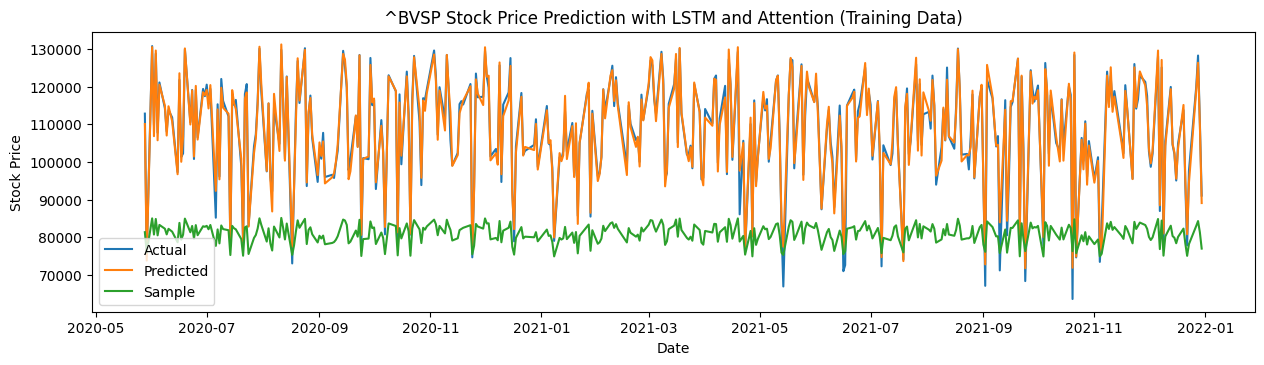

In [ ]:
# Plot the attention weights for the training data
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_train):], scaler.inverse_transform(y_train), label='Actual')
plt.plot(df.index[-len(train_predictions):], scaler.inverse_transform(train_predictions.reshape(-1,1)), label='Predicted')
plt.plot( df.index[-len(train_attention_weights):], scaler.inverse_transform(mean_attention_weights.reshape(-1,1)), label='Sample')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention (Training Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()


In [ ]:
dados_atencao = pd.DataFrame({"Date":df.index[-len(train_attention_weights):],"Attention":mean_attention_weights.reshape(-1)})

In [ ]:
dados_atencao.max()

Date         2021-12-30 00:00:00
Attention                0.32049
dtype: object